In [18]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS, add_constant, qqplot
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

In [19]:

def get_html(isin):
    '''
    Use ISIN number to generate URL, get data and transform to JSON. 
    It give out put as JSON object.
    '''
    link = 'https://api.divvydiary.com/symbols/'+isin
    response = requests.get(link)
    response_json = response.json()
    return response_json

In [20]:

def data_for_tsa(json):
    '''
    Loops through JSON file/object,
    give output as dataframe with date and amount of dividend.
    '''
    date = []
    amount = []
    for item in json['dividends']:
        date.append(item['payDate'])
        amount.append(item['amount'])
    data = pd.DataFrame({'date':pd.to_datetime(date, format ='%Y-%m-%d'), 'amount':amount})
    return data

In [32]:
plt.rcParams['figure.figsize'] = (14,6)

In [21]:
def plot_dividend(df, title = 'Dividend'):
    plt.scatter(x=df['date'], y=df['amount'])

In [22]:
exxon = get_html('US30231G1022')

In [23]:
df = data_for_tsa(exxon)

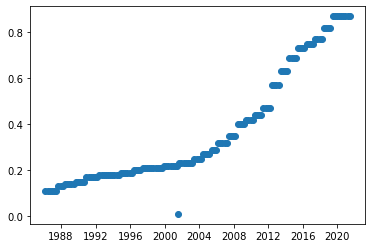

In [24]:
plot_dividend(df)

 `Decomposition`

In [25]:
df['timestamp'] = np.arange(len(df))
X = df[['timestamp']]
y= df['amount']
m= LinearRegression() #get trend
m.fit(X,y)
df['trend'] = m.predict(X)

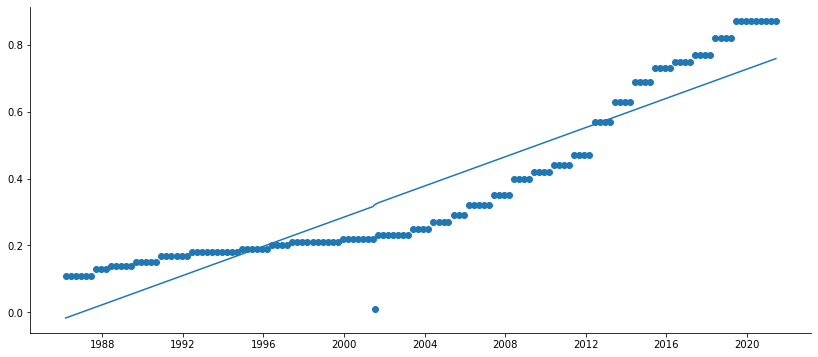

In [33]:
fig, ax1 = plt.subplots()
plt.scatter(df['date'],y = df['amount'])
plt.plot(df['date'],df['trend'])
sns.despine()

In [27]:
# get seasonality
seasonal_features = pd.get_dummies(df['date'].dt.month, prefix = 'month').set_index(df.index)

In [28]:
df = df.join(seasonal_features)

In [29]:
m2= LinearRegression()

In [30]:
X= df.drop(columns=['date', 'amount','timestamp','trend'])
y =df['amount']
m2.fit(X,y)
df['seasonal'] = m2.predict(X)

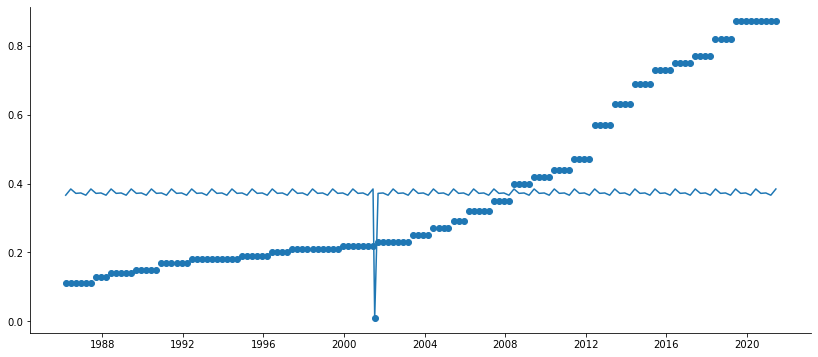

In [34]:
fig, ax1 = plt.subplots()
plt.scatter(df['date'],y = df['amount'])
plt.plot(df['date'],df['seasonal'])
sns.despine()

In [35]:
#model trend + seasonality
m3 = LinearRegression()

In [36]:
X= df.drop(columns=['date', 'amount','trend','seasonal'])
y =df['amount']

In [37]:
m3.fit(X,y)
df['trend_seasonal'] = m3.predict(X)

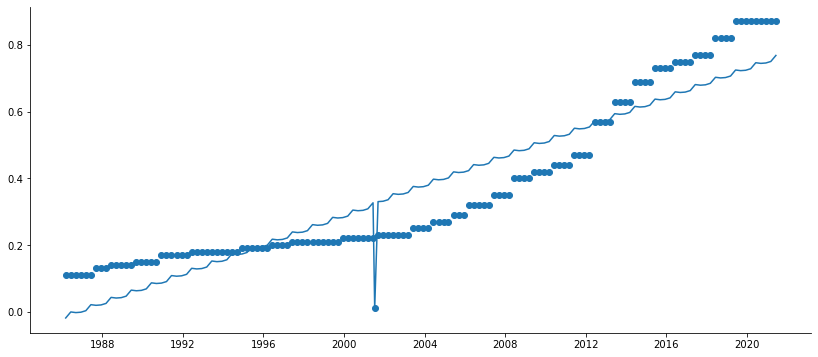

In [38]:
fig, ax1 = plt.subplots()
plt.scatter(df['date'],y = df['amount'])
plt.plot(df['date'],df['trend_seasonal'])
sns.despine()

In [39]:
df['remainder'] =df['amount']-df['trend_seasonal']

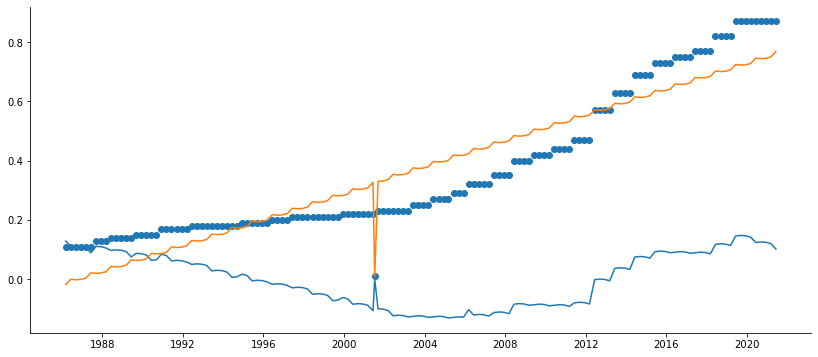

In [40]:
fig, ax1 = plt.subplots()
plt.scatter(df['date'],y = df['amount'])
plt.plot(df['date'],df['remainder'])
plt.plot(df['date'],df['trend_seasonal'])
sns.despine()

In [41]:
df['lag_1'] = df['remainder'].shift(1)

In [42]:
df.lag_1.corr(df['remainder'])

0.9806835876413513

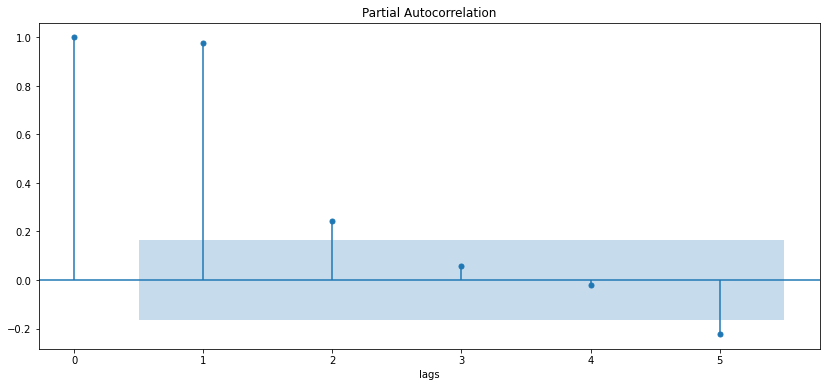

In [43]:
plot_pacf(df['remainder'], lags = 5)
plt.xlabel('lags');

Text(0.5, 0, 'lags')

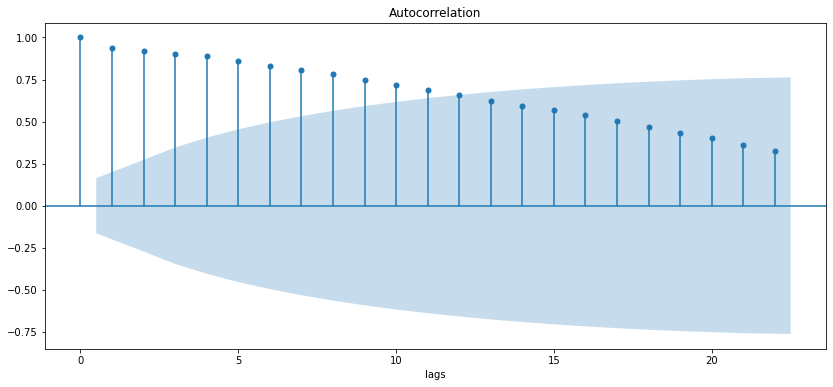

In [44]:
plot_acf(df['amount'] - df['trend'])
plt.xlabel('lags')

In [45]:
abs(df['remainder']).mean()

0.08051719081676405

<AxesSubplot:>

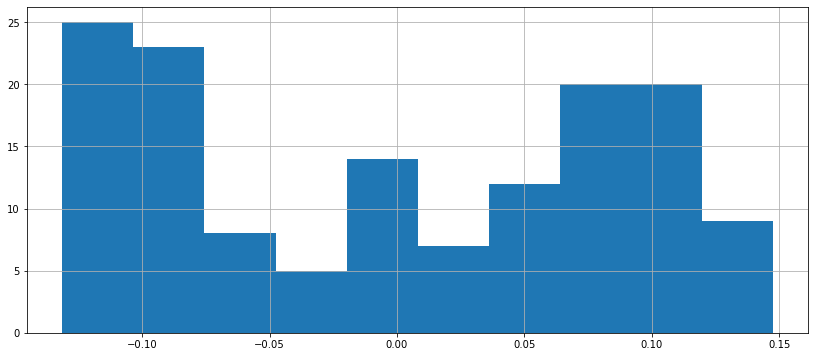

In [46]:
df['remainder'].hist()

In [47]:
m4 =LinearRegression() #Fit LiReg with trend seasonal and lag

In [48]:
df =df.dropna()

In [49]:
X= df.drop(columns=['date', 'amount','trend','seasonal','trend_seasonal','remainder'])
y =df['amount']

In [50]:
X.head()

,timestamp,month_3,month_6,month_7,month_9,month_12,lag_1
1,1,1,0,0,0,0,0.101845
2,2,0,0,0,0,1,0.119900
3,3,0,0,0,1,0,0.124428
4,4,0,1,0,0,0,0.125571
5,5,1,0,0,0,0,0.123648


In [51]:
m4.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [52]:
df['pred_lag'] = m4.predict(X)

In [53]:
df['error'] = df['amount'] - df['pred_lag']

In [54]:
abs(df['error']).mean()

0.007594618373721645